<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quite Complex Simulation

### Inevitable Imports

In [119]:
import scipy.integrate as integrate # for numerical solution od differential equations
import matplotlib.pyplot as plt     # for plots
import pandas as pd                 # for tables
import numpy as np                  # for matrices

%matplotlib

simulatedObjects = []

Using matplotlib backend: agg


### Display functions 

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


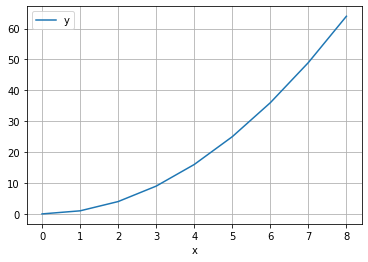

In [120]:
def displayData(data):
  display(pd.DataFrame(data))

def plotData(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  newax = None
  if ax is None:
    newax = df.plot.line(x = x, y = y)
  else:
    newax = df.plot.line(x = x, y = y, ax = ax)
  return newax

#=================#
# example of use  #
#=================#
#data = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (6, 36), (7, 49)]
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
plotData(data)
plt.grid(which='both')
displayData(data)

### Operators on Data Streams

In [121]:
def skip(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    next(innerGen)
  return innerGen

def take(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    yield next(innerGen)

def dilute(generator, ratio):
  innerGen = iter(generator)
  while True:
    skip(innerGen, ratio - 1)
    yield next(innerGen)

#=================#
# example of use  #
#=================#
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
partOfData = take(skip(data, 5), 2) # skip five, take two next, rest blow up
dilutedData = dilute(data, 2) # every odd
displayData(data)
displayData(partOfData)
displayData(dilutedData)


,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


,x,y
0,5,25
1,6,36


,x,y
0,1,1
1,3,9
2,5,25
3,7,49


### Some Theory 
$\left( y=f(x)  \right)$

### Compute One Step function

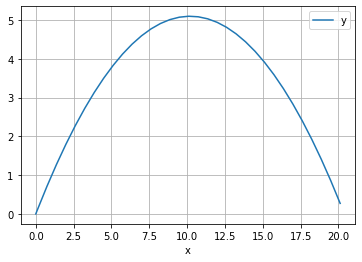

In [122]:
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)

  while True:
    message = solver.step()
    currentItem = {'time': solver.t, 'y': [*solver.y], 'yd': [*model(solver.t, solver.y)]}

    yield currentItem # send signal, inform about current result
    if (not(solver.status == 'running')):
        break
  return

#=================#
# example of use  #
#=================#
def model2D(time, state):
  velocity = state[:2]
  position = state[2:]
  acceleration = [0, -9.81]
  return [*acceleration, *velocity]

sim = compute(model2D, [10, 10, 0, 0])
result = []
for index, state in enumerate(sim):
  result.append(state)
  if index == 34: #magic number
    break

xy = list(map(lambda item: {'x': item['y'][2], 'y': item['y'][3]}, result))
plotData(xy)
plt.grid(which='both')

### Prepare and Simulate

In [0]:
def prepareSimulation(systemList, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  for system in systemList:
    system['solver'] = compute(system['model'], system['state0'], t0 = t0, t_bound = t_bound, max_step = max_step)
    system['finished'] = False
    system['result'] = next(system['solver'])#system['state0']

def simulate(systemList):
  for system in systemList:
    if system['finished'] == False:
      system['result'] = next(system['solver'])

### Nearly Infinite Simulation

In [0]:
def simulateInf(systemList, count = -1):
  cc = count
  while True:
    simulate(systemList)
    partialResult = {}
    for system in systemList:
      partialResult[system['name']] = {**system}
    yield partialResult
    cc = cc - 1
    if cc == 0:
      break # maximum steps reached, break it


### Example of Single System Simulation

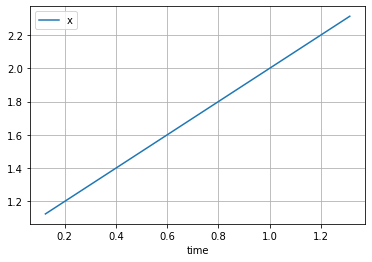

In [125]:
def movingObj(time, state):
  velocity = state[:3]
  position = state[3:]
  acceleration = [0, 0, 0]
  return [*acceleration, *velocity]

def rearangeResults(results, selectors):
  for result in results:
    partialResult = {}
    for selector in selectors:
      partialResult[selector['name']] = selector['selector'](result)
    yield partialResult

simulatedObjects = [{'state0': [1, 0.75, 0, 1, 1, 0], 'model': movingObj, 'name': 'obj1'}]
prepareSimulation(simulatedObjects)
simResults = list(simulateInf(simulatedObjects, 20))
simResultsRearanged = list(rearangeResults(simResults, 
  [
   {'name': 'time', 'selector': lambda item: item['obj1']['result']['time']},
   {'name': 'x', 'selector': lambda item: item['obj1']['result']['y'][3]},
   {'name': 'y', 'selector': lambda item: item['obj1']['result']['y'][4]}
   ]))

#simResults = list(justTwoFromResults(simResults, 'obj1', x = 3, y = 4))
#displayData(simResultsRearanged)
plotData(simResultsRearanged)#, x = 'x', y = 'y')
plt.grid(which='both')

### More Complex Simulation

#### Plane Model

In [0]:
def createPlaneModel(input):
  def planeModel(time, state):
    currentInput = input()
    
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetPosition = np.array(currentInput)

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs

    neededAcceleration = wantedVelocity - currentVelocity

    result = [*neededAcceleration, *currentVelocity]
    return result
  return planeModel

#### Rocket Model

In [0]:
def createRocketModel(rocketSystem, systemToDestroy):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']
    #print('currentInput', currentInput)
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetPosition = np.array(currentInput[3:])

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    #'''
    if wantedVelocityAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*neededAcceleration, *currentVelocity]
    return result
  return rocketModel


In [0]:
def createFixedTarget(x, y, z):
  def fixedPoint():
    return [x, y, z]
  return fixedPoint

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: generator 'dilute' raised StopIteration
  


,time,plane_x,plane_y,plane_f,rocket_x,rocket_y,rocket_f
0,0.450318,-31.389699,4.861720,False,576.600259,-493.956103,False
1,1.075318,-48.485185,17.354363,False,631.076186,-474.515398,False
2,1.700318,-52.443650,29.200254,False,646.325120,-453.967844,False
3,2.325318,-50.923419,39.150543,False,643.100037,-435.073287,False
4,2.950318,-46.916066,47.641584,False,630.752738,-417.686222,False
5,3.575318,-41.704987,55.223754,False,613.750278,-401.226801,False
6,4.200318,-35.886028,62.282624,False,594.345661,-385.224485,False
7,4.825318,-29.752054,69.050739,False,573.723332,-369.373352,False
8,5.450318,-23.452390,75.660121,False,552.524810,-353.488944,False
9,6.075318,-17.064851,82.183622,False,531.105705,-337.462361,False


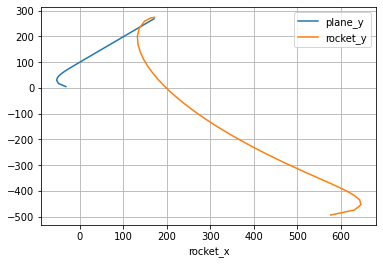

In [129]:
simulatedObjects = []
planeTarget = createFixedTarget(10000, 10000, 0)
plane = createPlaneModel(planeTarget)
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1],
    systemToDestroy = lambda : simulatedObjects[0])

simulatedObjects = [
  {'state0': [-100, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 1000, max_step = 0.0625)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))

ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['result']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['result']['y'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['result']['y'][4]},
  {'name': 'plane_f', 'selector': lambda item: item['plane']['finished']},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['result']['y'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['result']['y'][4]},
  {'name': 'rocket_f', 'selector': lambda item: item['rocket']['finished']},
  ]

reData = list(rearangeResults(simResults, ids))
toHitData = list(filter(lambda item: not item['plane_f'], reData))
displayData(toHitData)
ax = plotData(toHitData, x = 'plane_x', y = 'plane_y')
ax = plotData(toHitData, x = 'rocket_x', y = 'rocket_y', ax = ax)
plt.grid(which='both')

### Three System Simulation

Rocket was not destroyed, plane was shooted down.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: generator 'dilute' raised StopIteration


,time,plane_x,plane_y,plane_z,plane_f,rocket_x,rocket_y,rocket_z,rocket_f,antirocket_x,antirocket_y,antirocket_z,antirocket_f
0,0.231568,-19.127368,1.542683,999.845732,False,546.651526,-497.988955,4.018957,False,29.781177,-1.212034,0.003674,False
1,0.544068,-35.369312,6.582908,999.341709,False,592.374972,-490.549611,18.846572,False,102.204320,-13.691572,0.160705,False
2,0.856568,-44.650011,12.862027,998.713797,False,620.360838,-480.755950,38.272916,False,169.029989,-36.239163,0.848047,False
3,1.169068,-49.641599,19.244076,998.075592,False,636.430408,-470.312102,58.862371,False,231.223767,-65.805284,2.502758,False
4,1.481568,-51.926075,25.271409,997.472859,False,644.414084,-459.974750,79.096599,False,289.653754,-100.320075,5.566532,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,23.044068,158.972347,256.702587,974.329741,False,152.332050,262.976392,983.455257,False,202.884812,31.872061,793.000168,False
74,23.356568,162.216416,259.914439,974.008556,False,159.594039,269.432770,982.252832,False,199.446590,42.368975,802.510815,False
75,23.669068,165.460484,263.126291,973.687371,False,165.423306,272.565169,979.936372,False,196.402995,53.086797,811.870077,False
76,23.981568,168.704553,266.338143,973.366186,False,169.729129,273.537385,977.341105,False,193.745074,64.008321,821.073429,False


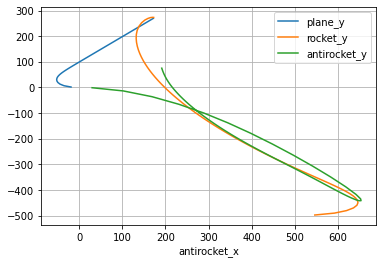

In [130]:
planeTarget = createFixedTarget(10000, 10000, 0)
plane = createPlaneModel(planeTarget)
rocketTarget = lambda : simulatedObjects[0]['state']['state'][3:] 
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1], 
    systemToDestroy = lambda : simulatedObjects[0], 
    )
antiRocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[2], 
    systemToDestroy = lambda : simulatedObjects[1], 
    )

simulatedObjects = [
  {'state0': [-100, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  {'state0': [250, 0, 0, 0, 0, 0], 'model': antiRocket, 'name': 'antiRocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 1000, max_step = 0.03125)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))

ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['result']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['result']['y'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['result']['y'][4]},
  {'name': 'plane_z', 'selector': lambda item: item['plane']['result']['y'][5]},
  {'name': 'plane_f', 'selector': lambda item: item['plane']['finished']},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['result']['y'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['result']['y'][4]},
  {'name': 'rocket_z', 'selector': lambda item: item['rocket']['result']['y'][5]},
  {'name': 'rocket_f', 'selector': lambda item: item['rocket']['finished']},
  {'name': 'antirocket_x', 'selector': lambda item: item['antiRocket']['result']['y'][3]},
  {'name': 'antirocket_y', 'selector': lambda item: item['antiRocket']['result']['y'][4]},
  {'name': 'antirocket_z', 'selector': lambda item: item['antiRocket']['result']['y'][5]},
  {'name': 'antirocket_f', 'selector': lambda item: item['antiRocket']['finished']},
  ]

reData = list(rearangeResults(simResults, ids))
#displayData(reData)
#ax = plotData(reData, x = 'plane_x', y = 'plane_y')
#ax = plotData(reData, x = 'rocket_x', y = 'rocket_y', ax = ax)
#ax = plotData(reData, x = 'antirocket_x', y = 'antirocket_y', ax = ax)

toHitData = list(filter(lambda item: not item['rocket_f'], reData))
displayData(toHitData)
ax = plotData(toHitData, x = 'plane_x', y = 'plane_y')
ax = plotData(toHitData, x = 'rocket_x', y = 'rocket_y', ax = ax)
ax = plotData(toHitData, x = 'antirocket_x', y = 'antirocket_y', ax = ax)
plt.grid(which='both')

### 3D Plot

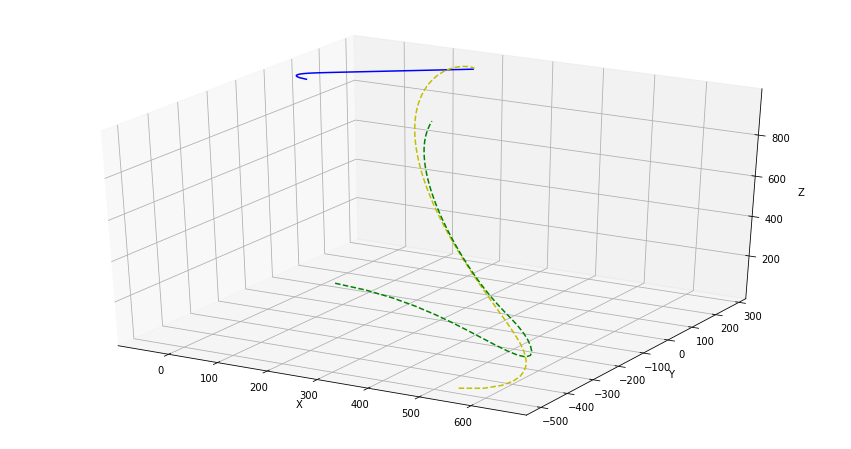

In [133]:
def selectValue(data, names):
  results = []
  for name in names:
    partialResult = []
    for item in data:
      partialResult.append(item[name])
    results.append(partialResult)
  return tuple(results)

plane_x, plane_y, plane_z = \
  selectValue(toHitData, ['plane_x', 'plane_y', 'plane_z'])
rocket_x, rocket_y, rocket_z = \
  selectValue(toHitData, ['rocket_x', 'rocket_y', 'rocket_z'])
antirocket_x, antirocket_y, antirocket_z = \
  selectValue(toHitData, ['antirocket_x', 'antirocket_y', 'antirocket_z'])

gph = plt.figure(figsize=(15,8)).gca(projection='3d')
#plotting red dotted lines with tiny markers
gph.plot(plane_x, plane_y, plane_z, "b-")
gph.plot(rocket_x, rocket_y, rocket_z, "y--")
gph.plot(antirocket_x, antirocket_y, antirocket_z, "g--")
gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()